In [2]:
# packages
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from functools import reduce


# local
from nb_util import autoreload, add_dirs
autoreload()

add_dirs(['../'])
from nash_util import concordance_stats as cs
from nash_util import nash_definitions as nd


In [3]:
# load Cougar network path data
file = 'REFDATA/COUGAR_NP_V02.xlsx'
c_dfs = {}

c_dfs['Fibrosis'] = pd.read_excel(file, sheet_name='Fibrosis')
c_dfs['Inflammation'] = pd.read_excel(file, sheet_name='Inflammation')
c_dfs['Ballooning'] = pd.read_excel(file, sheet_name='Ballooning')
c_dfs['Steatosis'] = pd.read_excel(file, sheet_name='Steatosis')

In [4]:
# load Cougar network path data
file = 'REFDATA/COUGAR_NP_V03.xlsx'
c_dfs = {}

c_dfs['Fibrosis'] = pd.read_excel(file, sheet_name='Fibrosis')
c_dfs['Inflammation'] = pd.read_excel(file, sheet_name='Inflammation')
c_dfs['Ballooning'] = pd.read_excel(file, sheet_name='Ballooning')
c_dfs['Steatosis'] = pd.read_excel(file, sheet_name='Steatosis')

In [5]:
def pick_col_level(df):
    col_levels = [i[1] if i[1] else i[0] for i in df.columns.to_flat_index()]
    df.columns = col_levels

In [6]:
df_list = []
for comp, df in c_dfs.items():
    df_temp = df.dropna(axis=0).copy()
    df_temp['CON_012'] = df_temp[['NP0','NP1','NP2']].apply(np.median,axis=1)
    df_temp['CON_A12'] = df_temp[['AIM','NP1','NP2']].apply(np.median,axis=1)
    df_temp['CON_0A2'] = df_temp[['NP0','AIM','NP2']].apply(np.median,axis=1)
    df_temp['CON_01A'] = df_temp[['NP0','NP1','AIM']].apply(np.median,axis=1)
    
    df_temp.drop(columns='PATHAI_ID',inplace=True)
    df_out = pd.melt(df_temp,
                     id_vars=['CASE_NAME','Visit'], 
                     value_vars=['AIM','NP0','NP1','NP2','CON_012','CON_A12','CON_0A2','CON_01A'],
                     var_name='SOURCE', 
                     value_name=comp, 
                     ignore_index=True).reset_index(drop=True)
    df_list.append(df_out)
c_df_tall = reduce(lambda x, y: pd.merge(x, y,how='inner',on=['CASE_NAME','Visit','SOURCE']).drop_duplicates(), df_list).reset_index(drop=True)


In [9]:
# needs for oscars table:
test = c_dfs['Inflammation'].copy()
test = test[~test['AIM'].isna()]
len(test)

639

In [34]:
enroll_df = c_df_tall.copy()
#F1-F4? Same for NAS=>4, NAS<=4 and NASH resolution Y/N.

enroll_df['Enroll FIB >= 4'] = enroll_df.apply(nd.A_F4_enroll,axis=1)

enroll_df['Enroll NAS'] = enroll_df.apply(nd.B_NAS_enroll,axis=1)
enroll_df['Enroll NAS & FIB'] = enroll_df.apply(nd.C_F4_NAS_enroll,axis=1)

enroll_df['NASH Resolution'] = enroll_df.apply(nd.nash_resolution,axis=1)


enroll_df['NAS'] = enroll_df[['Inflammation','Ballooning','Steatosis']].sum(axis=1)
enroll_df['NAS >= 4'] = (enroll_df['NAS']>=4)
enroll_df['NAS <= 4'] = (enroll_df['NAS']<=4)

In [18]:
def add_slide_link(slide):
    return f'=HYPERLINK("https://slides.pathai.com/slides/view/{slide}", {slide})'

In [35]:
enroll_disc = enroll_df[enroll_df['SOURCE'].isin(['AIM','CON_012'])].copy()
tdf = enroll_disc.pivot(
    columns=['SOURCE'],
    values=['Fibrosis','NAS >= 4','NAS <= 4','NASH Resolution'],
    index=['CASE_NAME','Visit'])
for v in ['Fibrosis','NAS >= 4','NAS <= 4','NASH Resolution']:
    tdf.loc[:,(v,'AGREE')] = (tdf.loc[:,(v,'AIM')]==tdf.loc[:,(v,'CON_012')])
tdf = tdf.reset_index()
tdf

CASE_NAME     Visit Fibrosis         NAS >= 4         NAS <= 4          \
SOURCE                          AIM CON_012      AIM CON_012      AIM CON_012   
0       101-0380  Baseline        2       3    False   False     True    True   
1       101-0380  Month-12        1       1    False   False     True    True   
2       101-0540  Baseline        2       2     True    True     True   False   
3       101-0540  Month-12        3       2     True    True    False   False   
4       101-0600  Baseline        3       2     True   False     True    True   
..           ...       ...      ...     ...      ...     ...      ...     ...   
600     183-1048  Baseline        2       1     True    True    False   False   
601     183-1048  Month-12        1       1     True    True    False    True   
602     183-1078  Month-12        3       3     True   False    False    True   
603     184-0865  Baseline        3       3    False    True     True   False   
604     184-0865  Month-12        3       3     True    True     True    True   

       NASH Resolution         Fibrosis NAS >= 4 NAS <= 4 NASH Resolution  
SOURCE             AIM CON_012    AGREE    AGREE    AGREE           AGREE  
0                False   False    False     True     True            True  
1                 True    True     True     True     True            True  
2                False   False     True     True    False            True  
3                False   False    False     True     True            True  
4                False   False    False    False     True            True  
..                 ...     ...      ...      ...      ...             ...  
600              False   False    False     True     True            True  
601              False   False     True     True    False            True  
602              False   False     True    False    False            True  
603              False   False     True    False    False            True  
604              False   False     True     True     True            True  

[605 rows x 14 columns]

In [36]:
# add slide IDs back in for theses cases for output
tc_id = c_dfs['Fibrosis'][['CASE_NAME','Visit','PATHAI_ID']].rename(columns={'PATHAI_ID':'TC_ID'})
he_id = c_dfs['Steatosis'][['CASE_NAME','Visit','PATHAI_ID']].rename(columns={'PATHAI_ID':'HE_ID'})


slide_id = he_id.merge(tc_id, how='left',on=['CASE_NAME','Visit']).drop_duplicates()

slide_id['HE_ID'] = slide_id['HE_ID'].astype('Int64')
slide_id['TC_ID'] = slide_id['TC_ID'].astype('Int64')

edf_with_slides = tdf.merge(slide_id, how='left',on=['CASE_NAME','Visit']).drop_duplicates()

edf_with_slides['HE_ID'] = edf_with_slides['HE_ID'].apply(add_slide_link)
edf_with_slides['TC_ID'] = edf_with_slides['TC_ID'].apply(add_slide_link)


with pd.ExcelWriter('OUTPUTS/CiriusEnrollmentDiscSlideList_v1_070221.xlsx', mode='w') as w:
    edf_with_slides.to_excel(w, sheet_name=f'Enrollment Discordance')

/Users/charles.biddle.snead/opt/miniconda3/envs/sp/lib/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [24]:
edf_with_slides

,CASE_NAME,Visit,SOURCE,Fibrosis,Inflammation,Ballooning,Steatosis,Enroll FIB >= 4,Enroll NAS,Enroll NAS & FIB,HE_ID,TC_ID
0,183-1048,Month-12,AIM,1.0,1.0,1.0,3.0,False,True,False,"=HYPERLINK(""https://slides.pathai.com/slides/v...","=HYPERLINK(""https://slides.pathai.com/slides/v..."
1,183-1021,Month-12,AIM,3.0,2.0,1.0,2.0,False,True,False,"=HYPERLINK(""https://slides.pathai.com/slides/v...","=HYPERLINK(""https://slides.pathai.com/slides/v..."
2,167-0840,Month-12,AIM,3.0,1.0,1.0,0.0,False,False,False,"=HYPERLINK(""https://slides.pathai.com/slides/v...","=HYPERLINK(""https://slides.pathai.com/slides/v..."
3,180-0767,Month-12,AIM,1.0,1.0,0.0,1.0,False,False,False,"=HYPERLINK(""https://slides.pathai.com/slides/v...","=HYPERLINK(""https://slides.pathai.com/slides/v..."
4,167-0774,Month-12,AIM,3.0,1.0,2.0,3.0,False,True,False,"=HYPERLINK(""https://slides.pathai.com/slides/v...","=HYPERLINK(""https://slides.pathai.com/slides/v..."
...,...,...,...,...,...,...,...,...,...,...,...,...
4835,161-0854,Month-12,CON_01A,2.0,0.0,0.0,3.0,False,False,False,"=HYPERLINK(""https://slides.pathai.com/slides/v...","=HYPERLINK(""https://slides.pathai.com/slides/v..."
4836,115-0946,Month-12,CON_01A,2.0,0.0,0.0,0.0,False,False,False,"=HYPERLINK(""https://slides.pathai.com/slides/v...","=HYPERLINK(""https://slides.pathai.com/slides/v..."
4837,181-0816,Month-12,CON_01A,2.0,2.0,2.0,2.0,False,True,False,"=HYPERLINK(""https://slides.pathai.com/slides/v...","=HYPERLINK(""https://slides.pathai.com/slides/v..."
4838,102-0862,Month-12,CON_01A,1.0,1.0,0.0,2.0,False,False,False,"=HYPERLINK(""https://slides.pathai.com/slides/v...","=HYPERLINK(""https://slides.pathai.com/slides/v..."


In [14]:
from sklearn.metrics import precision_recall_fscore_support as prfs
from sklearn.metrics import balanced_accuracy_score, accuracy_score, cohen_kappa_score
from sklearn.utils import resample

def pick_col_level(df):
    col_levels = [i[1] if i[1] else i[0] for i in df.columns.to_flat_index()]
    df.columns = col_levels

def get_ci(x):
    cis = np.percentile(x,[2.5,97.5])
    return pd.Series({
        'lci':cis[0],
        'uci':cis[1]
    })

def get_binary_aggrement_stats(a,b):
    
    pls = np.sort(np.unique(a))
    
    pl_ppv, pl_tpr, pl_f1, pl_n = prfs(a, b)
    ppv, tpr, f1, _ = prfs(a, b, average='weighted')
    acc = accuracy_score(a, b)
    bal_acc = balanced_accuracy_score(a, b)
    kappa = cohen_kappa_score(a, b)
    
    avg_stats = pd.DataFrame({
        'PPV':ppv,
        'TPR':tpr,
        'F1':f1,
        'Accuracy':acc,
        'Balanced Accuracy':bal_acc,
        'Kappa':kappa
    },index=[0])
    
    pl_stats = pd.DataFrame({
        'Labels':pls,
        'PPV':pl_ppv,
        'TPR':pl_tpr,
        'F1':pl_f1,
        'N':pl_n
    })
    
    return avg_stats, pl_stats

def get_agg_stats(a,b,stratify=None):
    if stratify is not None:
        a, b, stratify = cs.clean_nans([a, b, stratify])
        a = a.astype(str)
        b = b.astype(str)
        strat_str = stratify.astype(str)
    else:
        a, b = cs.clean_nans([a, b])
        a = a.astype(str)
        b = b.astype(str)
        
    avg_stats, pl_stats = get_binary_aggrement_stats(a, b)

    avg_l = []
    pl_l = []

    for ii in range(10000):
        a_bs, b_bs = resample(a, b, stratify=stratify)
        avg_bs, pl_bs = get_binary_aggrement_stats(a_bs, b_bs)

        avg_l.append(avg_bs)

        pl_t = pl_bs.melt(id_vars = ['Labels'],var_name='Stat',value_name='Value')
        pl_l.append(pl_t)

    pldf = pd.concat(pl_l)
    avgdf = pd.concat(avg_l)

    t = avgdf.apply(lambda x: np.percentile(x,[2.5,97.5]))
    t = pd.concat([avg_stats,t])
    t.index = ['pe','lci','uci']
    t = t.T
    t.index.name = 'Stat'
    t = t.reset_index()

    q = pldf.groupby(['Labels','Stat']).apply(get_ci).reset_index()
    q = pl_stats.melt(id_vars = ['Labels'],var_name='Stat',value_name='pe').merge(q,how='left',on=['Labels','Stat']).drop_duplicates()
    
    return t, q


def ret_scores(df):
    av_stats = []
    pl_stats = []

    a, b = get_binary_aggrement_stats(df['CON_A12'],df['NP0'])
    av_stats.append(a)
    pl_stats.append(b.melt(id_vars = ['Labels'],var_name='Stat',value_name='Value'))

    a, b = get_binary_aggrement_stats(df['CON_0A2'],df['NP1'])
    av_stats.append(a)
    pl_stats.append(b.melt(id_vars = ['Labels'],var_name='Stat',value_name='Value'))

    a, b = get_binary_aggrement_stats(df['CON_01A'],df['NP2'])
    av_stats.append(a)
    pl_stats.append(b.melt(id_vars = ['Labels'],var_name='Stat',value_name='Value'))

    pldf = pd.concat(pl_stats)
    avgdf = pd.concat(av_stats)

    t = avgdf.apply(np.mean, axis=0)
    t = t.T
    t.index.name = 'Stat'
    t = t.reset_index()

    q = pldf.groupby(['Labels','Stat']).apply(np.mean).reset_index()

    return t, q
        
        
def get_avg_agg_stats_spec(dfi):
    
    df = dfi.copy()
    df = df.dropna()
    df = df.astype(str)
    df = df.reset_index(drop=True)
    
    av_mean, pl_mean = ret_scores(df)
    av_mean.columns = ['Stat','pe']
    pl_mean.columns = ['Labels','Stat','pe']

    av_l = []
    pl_l = []
    for ii in range(10000):
        ridx = resample(df.index, stratify=df['CON_012'])
        av_bs, pl_bs = ret_scores(df.loc[ridx,:])        
        av_l.append(av_bs)
        pl_l.append(pl_bs)
    
    av_ci = pd.concat(av_l)
    av_ci.columns = ['Stat','Value']
    
    av_out = av_ci.groupby(['Stat']).apply(get_ci).reset_index()
    av_out = av_mean.merge(av_out, how='left',on=['Stat']).drop_duplicates()
    
    pl_ci = pd.concat(pl_l)
    pl_out = pl_ci.groupby(['Labels','Stat']).apply(get_ci).reset_index()
    pl_out = pl_mean.merge(pl_out,how='left',on=['Labels','Stat']).drop_duplicates()
        
    return av_out, pl_out

In [15]:
end_points = ['Enroll FIB >= 4','Enroll NAS','Enroll NAS & FIB']

av_list = []
pl_list = []

for ep in end_points:

    a = enroll_df.reset_index().pivot(
        index=['CASE_NAME','Visit'],
        columns=['SOURCE'],
        values=[ep]
    )
    
    a = a.reset_index()
    pick_col_level(a)
    a.dropna(inplace=True)

    av_gloo, pl_gloo = get_avg_agg_stats_spec(a)
    av_gloo['Kind'] = 'GLOO'
    pl_gloo['Kind'] = 'GLOO'
    av_gloo['End Point'] = ep
    pl_gloo['End Point'] = ep


    av_aim, pl_aim = get_agg_stats(a['CON_012'],a['AIM'],stratify=a['CON_012'])
    av_aim['Kind'] = 'AIM'
    pl_aim['Kind'] = 'AIM'
    av_aim['End Point'] = ep
    pl_aim['End Point'] = ep

    av_list.append(pd.concat([av_aim,av_gloo]))
    pl_list.append(pd.concat([pl_aim,pl_gloo]))

av_all = pd.concat(av_list)
pl_all = pd.concat(pl_list)

In [17]:
pl_all

,Labels,Stat,pe,lci,uci,Kind,End Point
0,False,PPV,0.992995,0.986087,0.998249,AIM,Enroll FIB >= 4
1,True,PPV,0.558824,0.439976,0.703704,AIM,Enroll FIB >= 4
2,False,TPR,0.974227,0.960481,0.986254,AIM,Enroll FIB >= 4
3,True,TPR,0.826087,0.652174,0.956522,AIM,Enroll FIB >= 4
4,False,F1,0.983521,0.975652,0.990493,AIM,Enroll FIB >= 4
5,True,F1,0.666667,0.545455,0.791667,AIM,Enroll FIB >= 4
6,False,N,582.000000,582.000000,582.000000,AIM,Enroll FIB >= 4
7,True,N,23.000000,23.000000,23.000000,AIM,Enroll FIB >= 4
0,False,F1,0.977943,0.971534,0.983591,GLOO,Enroll FIB >= 4
1,False,N,579.333333,575.333333,583.333333,GLOO,Enroll FIB >= 4


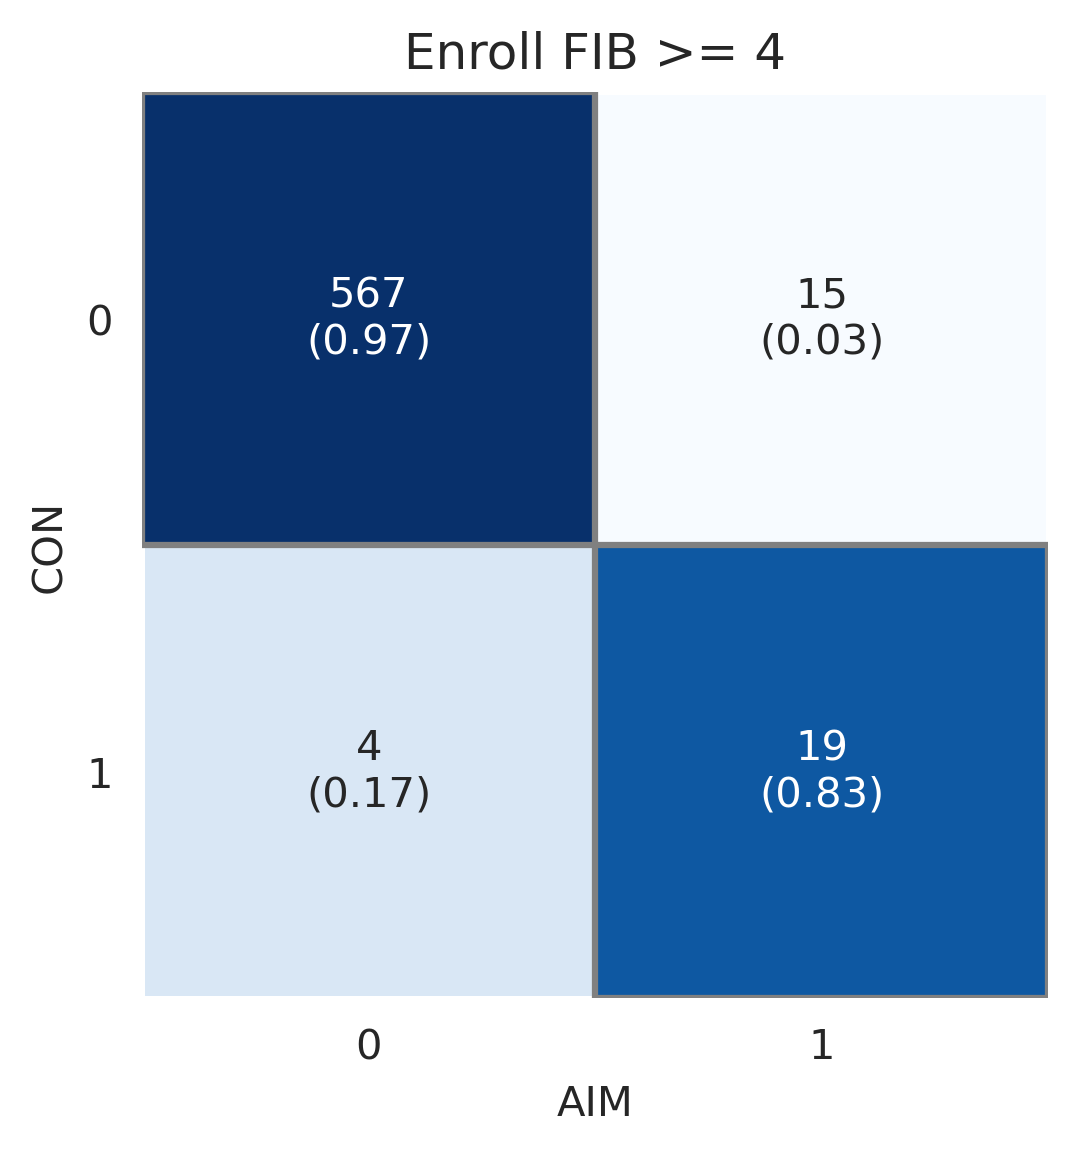

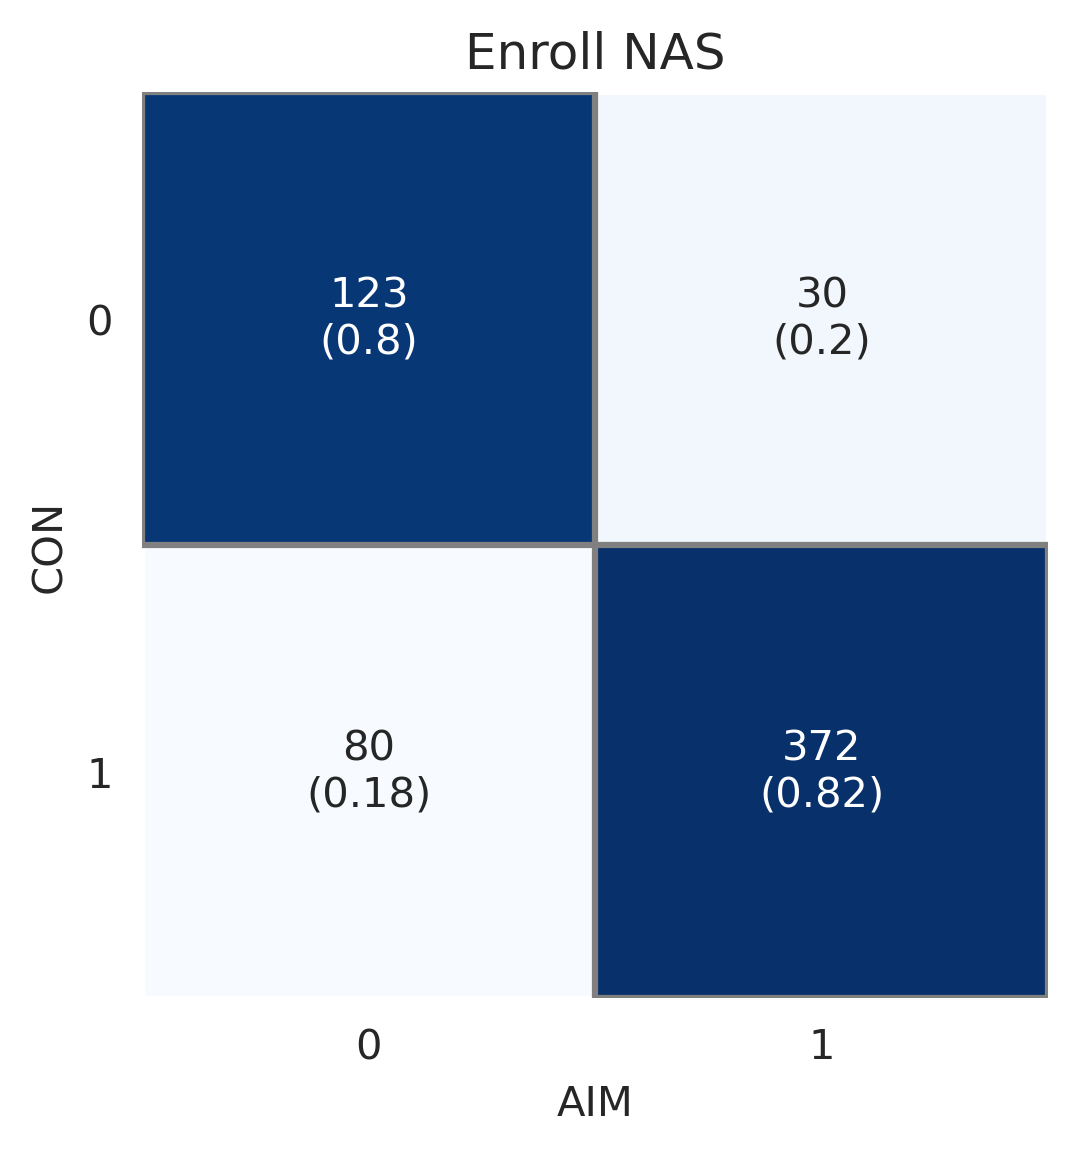

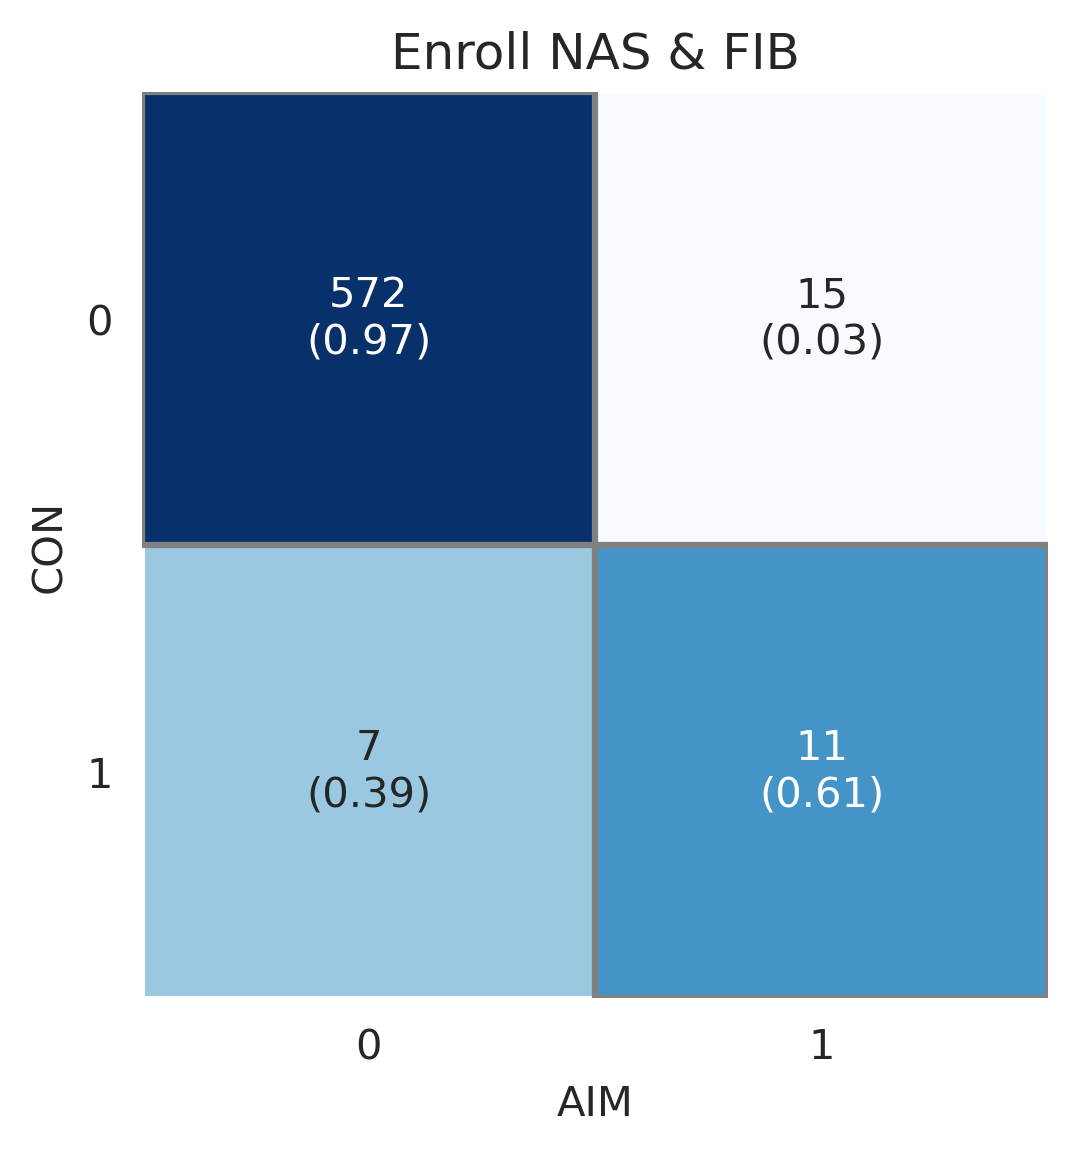

In [196]:
es_list = []
es_pw_list = []
for ep in ['Enroll FIB >= 4','Enroll NAS','Enroll NAS & FIB']:
    a = enroll_df.pivot(
        index=['CASE_NAME','Visit'],
        columns=['SOURCE'],
        values=[ep]
    )
    a = a.reset_index()
    pick_col_level(a)
    
    stats_str, _ = cs.legacy_stats(cs.agg_rate,a['AIM'],a['NP0'],a['NP1'],a['NP2'])
    stats_str['Enrollment Measure']=ep
    stats_str['Metric'] = 'Agreement Rate'
    es_list.append(stats_str)
    
    
    stats_str, _ = cs.pairwise_stats(cs.agg_rate,a['AIM'],a['NP0'],a['NP1'],a['NP2'])
    stats_str['Enrollment Measure']=ep
    stats_str['Metric'] = 'Agreement Rate'
    es_pw_list.append(stats_str)
    
    _ = cs.plot_confusion_table(a['CON'],a['AIM'],name_a='CON',name_b='AIM',title=ep)
    plt.show()
es_leg_stats = pd.concat(es_list)
es_pw_stats = pd.concat(es_pw_list)

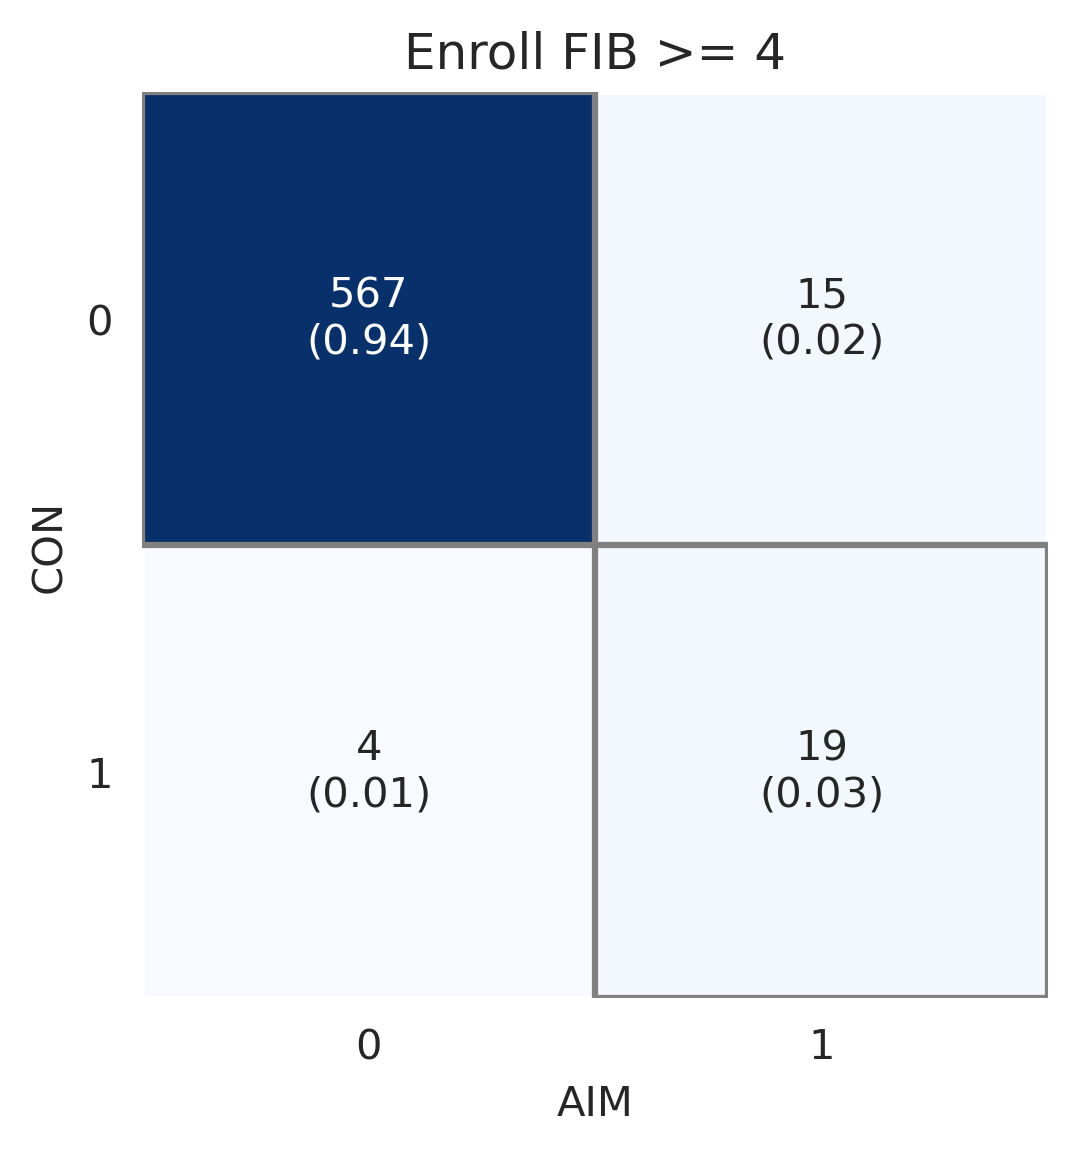

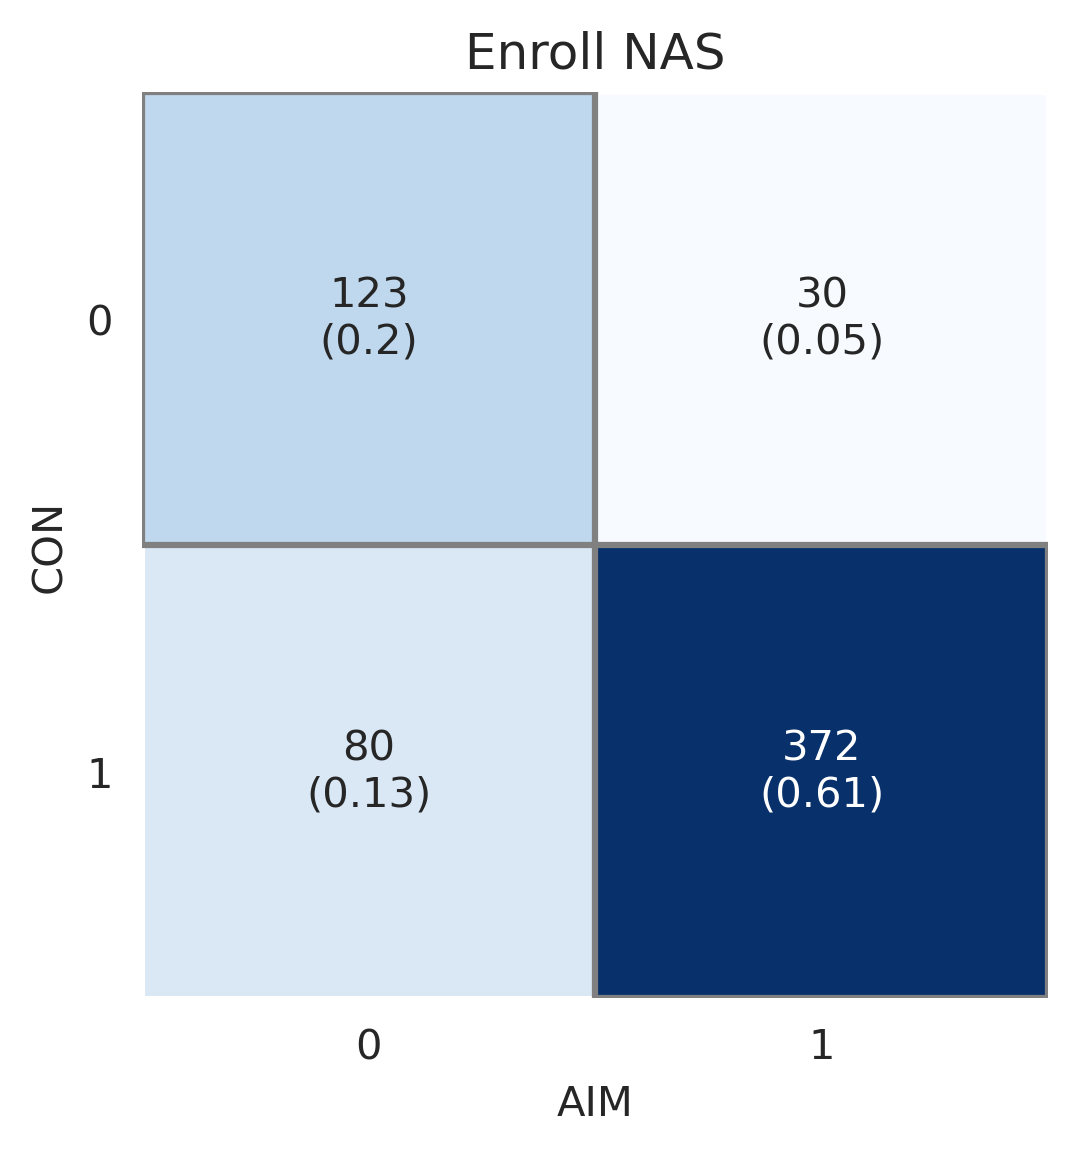

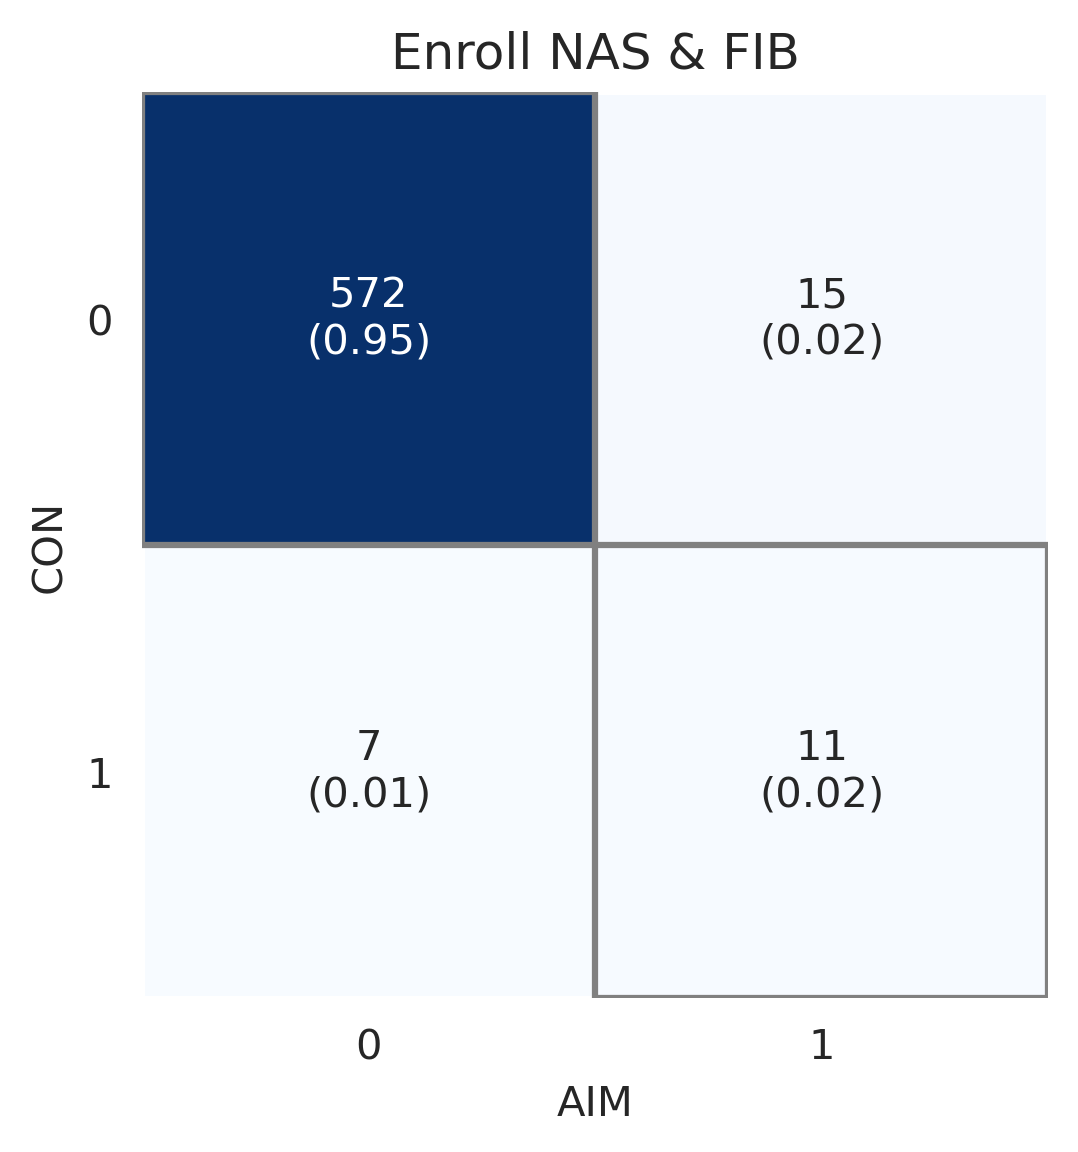

In [19]:
es_list = []
es_pw_list = []
for ep in ['Enroll FIB >= 4','Enroll NAS','Enroll NAS & FIB']:
    a = enroll_df.pivot(
        index=['CASE_NAME','Visit'],
        columns=['SOURCE'],
        values=[ep]
    )
    a = a.reset_index()
    pick_col_level(a)
    

    
    _ = cs.plot_confusion_table(a['CON_012'],a['AIM'],name_a='CON',name_b='AIM',title=ep, norm='all')
    plt.show()

In [197]:
es_pw_stats

,AIM PW AVG,NP PW AVG,NP0-NP1,NP0-NP2,NP1-NP2,N,Enrollment Measure,Metric
0,"0.95 (0.93, 0.96)","0.94 (0.92, 0.95)","0.97 (0.95, 0.98)","0.92 (0.9, 0.94)","0.93 (0.91, 0.95)",605,Enroll FIB >= 4,Agreement Rate
0,"0.79 (0.77, 0.82)","0.78 (0.75, 0.8)","0.76 (0.73, 0.8)","0.81 (0.78, 0.84)","0.77 (0.73, 0.8)",605,Enroll NAS,Agreement Rate
0,"0.95 (0.94, 0.97)","0.95 (0.93, 0.96)","0.97 (0.95, 0.98)","0.94 (0.92, 0.95)","0.93 (0.91, 0.95)",605,Enroll NAS & FIB,Agreement Rate


In [199]:
es_leg_stats

,AIM v CON,NP PW AVG,NP0-NP1,NP0-NP2,NP1-NP2,N,Enrollment Measure,Metric
0,"0.97 (0.95, 0.98)","0.94 (0.92, 0.95)","0.97 (0.95, 0.98)","0.92 (0.9, 0.94)","0.93 (0.91, 0.95)",605,Enroll FIB >= 4,Agreement Rate
0,"0.83 (0.8, 0.86)","0.78 (0.76, 0.8)","0.76 (0.73, 0.8)","0.81 (0.78, 0.84)","0.77 (0.73, 0.8)",605,Enroll NAS,Agreement Rate
0,"0.97 (0.95, 0.98)","0.95 (0.93, 0.96)","0.97 (0.95, 0.98)","0.94 (0.92, 0.96)","0.93 (0.91, 0.95)",605,Enroll NAS & FIB,Agreement Rate


In [179]:
a

,level_0,index,CASE_NAME,Visit,AIM,CON,NP0,NP1,NP2
0,0,0,101-0380,Baseline,False,False,False,False,False
1,1,1,101-0380,Month-12,False,False,False,False,False
2,2,2,101-0540,Baseline,False,False,False,False,False
3,3,3,101-0540,Month-12,False,False,False,False,False
4,4,4,101-0600,Baseline,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
600,600,600,183-1048,Baseline,False,False,False,False,False
601,601,601,183-1048,Month-12,False,False,False,False,False
602,602,602,183-1078,Month-12,False,False,False,False,False
603,603,603,184-0865,Baseline,False,False,False,False,False


In [91]:
a = c_df_tall.pivot(
    index=['CASE_NAME','SOURCE'],
    columns=['Visit'],
    values=['Fibrosis','Inflammation','Ballooning','Steatosis']
)

In [149]:
a.loc[(slice(None),'AIM'),(slice(None),'Month-12')].apply(nd.B_NAS_enroll,axis=1).value_counts()

Month-12
True        181
False       128
dtype: int64

In [139]:
b.value_counts()

Baseline  Month-12
False     False       256
True      False        12
False     True         10
True      True          1
dtype: int64

In [154]:
a.loc[(slice(None),'NP2'),(slice(None),'Month-12')].apply(nd.nash_resolution,axis=1).value_counts()

Month-12
False       275
True         34
dtype: int64

In [133]:
a.loc[(slice(None),['NP0','NP1','NP2']),(slice(None),'Baseline')].apply(nd.C_F4_NAS_enroll,axis=1).reset_index(level=[1]).value_counts()

SOURCE  Baseline
NP0     False       296
NP1     False       287
NP2     False       279
        True         17
NP1     True          9
dtype: int64